# <center>Trabajo Práctico 1</center>

## Grupo 4:


| Nombre  | Padrón |
| ------------- | ------------- |
| Ian Gauler | 109437  |
| Valentina Gemetto  | 109667  |
| Agustin Puglisi  | 104245 |
| Ezequiel Vilardo  | 104980  |

Generador de números al azar elegido:
# <center>Mersenne Twister</center>

---

# Importación de librerías

Para este Trabajo Práctico necesitaremos usar varias funciones de librerías de Python. A continuación las importaremos:

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import scipy.stats as stats

---

# Ejercicio 1:

Sobre el generador de números al azar elegido, se pide:
* Implementarlo en función de la especificación del mismo.
* Modificarlo (si aplica) para obtener números al azar entre 0 y 1
* Realizar los gráficos que se consideren adecuados para mostrar las distribuciones de números
pseudoaleatorios generados (explicar que se busca interpretar con cada uno de los gráficos)

## Implementacion

Lo primero que haremos es setear las constantes del algoritmo que cumplen con una serie de condiciones:
* W: word size (in number of bits)
* N: degree of recurrence
* M: middle word, an offset used in the recurrence relation defining the series x, 1 <= m < n
* R: separation point of one word, or the number of bits of the lower bitmask, 0 <= r <= w - 1
* A: coefficients of the rational normal form twist matrix
* B, C: TGFSR(R) tempering bitmasks
* S, T: TGFSR(R) tempering bit shifts
* U, D, L: additional Mersenne Twister tempering bit shifts/masks

Vamos a tomar las constantes del
[MT19937, Motor de Mersenne twister de 32 bits (Matsumoto y Nishimura, 1998)](https://learn.microsoft.com/es-es/cpp/standard-library/mersenne-twister-engine-class?view=msvc-170).\
Ya que según nuestro paper, es el que mejor se comporta en cuanto a la distribución de los números generados. Con un periodo de hasta $2^{19937}-1$.

In [2]:
W = 32
N = 624
M = 397
R = 31
A = 0x9908B0DF
U = 11
D = 0xFFFFFFFF
S = 7
B = 0x9D2C5680
T = 15
C = 0xEFC60000
L = 18
F = 1812433253
W_MASK = pow(2, W) - 1

### Pseudocodigo de ejemplo hecho en C

De [Wikipedia](https://en.wikipedia.org/wiki/Mersenne_Twister) obtenemos un pseudocódigo del algoritmo hecho en C:

```c
// Create a length n array to store the state of the generator
 int[0..n-1] MT
 int index := n+1
 const int lower_mask = (1 << r) - 1 // That is, the binary number of r 1's
 const int upper_mask = lowest w bits of (not lower_mask)

 // Initialize the generator from a seed
 function seed_mt(int seed) {
     index := n
     MT[0] := seed
     for i from 1 to (n - 1) { // loop over each element
         MT[i] := lowest w bits of (f * (MT[i-1] xor (MT[i-1] >> (w-2))) + i)
     }
 }

 // Extract a tempered value based on MT[index]
 // calling twist() every n numbers
 function extract_number() {
     if index >= n {
         if index > n {
           error "Generator was never seeded"
           // Alternatively, seed with constant value; 5489 is used in reference C code[54]
         }
         twist()
     }

     int y := MT[index]
     y := y xor ((y >> u) and d)
     y := y xor ((y << s) and b)
     y := y xor ((y << t) and c)
     y := y xor (y >> l)

     index := index + 1
     return lowest w bits of (y)
 }

 // Generate the next n values from the series x_i
 function twist() {
     for i from 0 to (n-1) {
         int x := (MT[i] and upper_mask)
                   | (MT[(i+1) mod n] and lower_mask)
         int xA := x >> 1
         if (x mod 2) != 0 { // lowest bit of x is 1
             xA := xA xor a
         }
         MT[i] := MT[(i + m) mod n] xor xA
     }
     index := 0
 }
```

### Implementamos el código en Python:

Como el algoritmo implementado genera valores entre 0 y 2^32, si buscamos modificarlo para que su salida este entre 0 y 1 lo unico que debemos hacer es dividir el numero aleatorio obtenido por 2^32 - 1.

In [3]:
#Genero una mascara superior y inferior
lower_mask = (1 << R) - 1               # Número binario que consiste en mover un 1, R veces a la izquierda y restarle 1
upper_mask = (~lower_mask) & W_MASK

#Definimos la clase MT19937 que genera numeros pseudoaleatorios de 32 bits a partir de una semilla
class MT19937:
    def __init__(self, seed):
        """
        Inicializa el generador mersenne-twister con una semilla
        """
        self.index = N
        self.state = [0] * N
        self._seed(seed)

    def _seed(self, seed):
        """
        Inicializa la semilla para el generador
        """
        self.state[0] = seed & W_MASK
        for i in range(1, N):
            self.state[i] = (F * (self.state[i-1] ^ (self.state[i-1] >> (W-2))) + i) & W_MASK

    #Genera los siguientes N numeros pseudoaleatorios
    def twist(self):
        for i in range(N):
            x = (self.state[i] & upper_mask) + (self.state[(i+1) % N] & lower_mask)
            xA = x >> 1
            if x % 2 != 0:
                xA ^= A
            self.state[i] = self.state[(i+M) % N] ^ xA
        self.index = 0

    #Extrae el siguiente numero segun el indice y si es necesario llama al "twist" para volver a generar mas numeros
    def next(self):
        if self.index >= N:
            self.twist()

        y = self.state[self.index]
        y ^= (y >> U) & D
        y ^= (y << S) & B
        y ^= (y << T) & C
        y ^= y >> L
        self.index += 1
        return y & W_MASK
    
    # Modificacion para generar numeros entre 0 y 1
    def next_uniforme(self):
        return mt.next() / (pow(2, W) - 1)


# Realizamos una prueba de los primeros 10 numeros generados
mt = MT19937(0)
for i in range(10):
    print(mt.next())
#genera numeros entre 0 y 2^w, en este caso 2^32

2357136044
2546248239
3071714933
3626093760
2588848963
3684848379
2340255427
3638918503
1819583497
2678185683


### Comprobamos que funcione de manera correcta

Lo probamos con una muestra grande

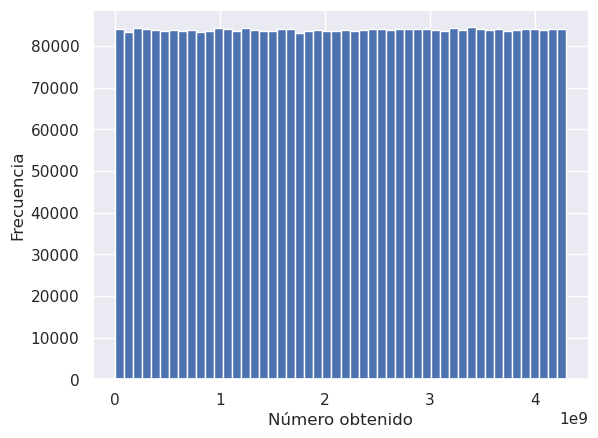

In [4]:
#Con una generacion bastante grande - Ejecutar solo cuando sea necesario
mt = MT19937(0)
resultado = [mt.next() for _ in range(pow(2, 22))]
plt.hist(resultado, 50)

plt.ylabel('Frecuencia')
plt.xlabel('Número obtenido')

plt.show()

Claramente, la distribución se observa aproximadamente uniforme. Ahora, veamos qué sucede cuando creamos una muestra de menor tamaño

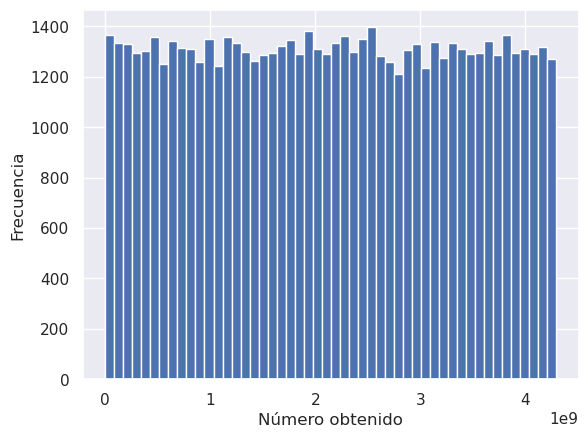

In [5]:
mt = MT19937(0)
resultado = [mt.next() for i in range(pow(2, 16))]
plt.hist(resultado, 50)

plt.ylabel('Frecuencia')
plt.xlabel('Número obtenido')

plt.show()

Al reducir la cantidad podemos ver que la generacion sigue siendo uniforme pero con unos pequeños picos.

## Gráficos correspondientes

Si queremos generar un grafico para observar la nueva salida...

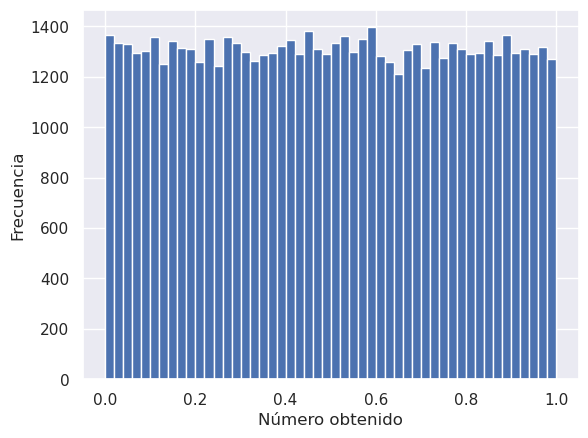

In [6]:
mt = MT19937(0)
resultado = [mt.next_uniforme() for i in range(pow(2, 16))]
plt.hist(resultado, 50)


plt.ylabel('Frecuencia')
plt.xlabel('Número obtenido')

plt.show()

Podemos observar que se mantiene la uniformidad en la salida pero dentro de los nuevos valores buscados.



---



# Ejercicio 2


En este ejercicio se busca aplicar distintos test estadísticos vistos en la materia para evaluar tanto el comportamiento del generador de números pseudoaleatorios elegido como el comportamiento del generador implementado por otro grupo. El grupo al cual deben evaluar el generador se encuentra en la planilla de grupos en Drive.

Para esta tarea se debe solicitar al otro equipo uno o más lotes de números generado de los tamaños que se necesiten. El equipo que haya generado los números debe incluir en la notebook entregada el código utilizado
para generar los mismos.

a) Sobre los generadores implementados en el ejercicio 1:
* Proponer, y realizar,  al menos 3 tests para evaluar su comportamiento.
* Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.

b) Sobre el generador implementado por el grupo asignado:
* Proponer, y realizar,  al menos 3 tests para evaluar su comportamiento.
* Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.
* Comparar los resultados obtenidos para este generador con los obtenidos en el punto a



---



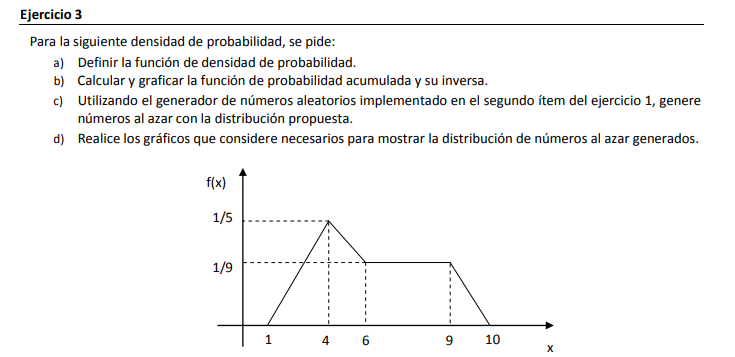



---



# Ejercicio 4

La llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa λ vehículos/hora. En el trabajo práctico se incluye un archivo con números pseudoaleatorios que representan los tiempos entre arribos de dichos vehículos.
* Realice una estimación de la tasa de arribos y proponga un test para evaluar si los números pseudoaleatorios provistos siguen la distribución esperada. 
* Utilizando el generador implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes. Graficar la cantidad de arribos en función del tiempo. 
* Generar 1000 realizaciones del proceso de Poisson para estimar las siguientes probabilidades:
    1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.
    2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
    3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.
    Comparar con los valores teóricos.

## Cálculo de $\lambda$

Nos dicen que la llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa $\lambda$.

Como se supone que las llegadas de los vehículos al estacionamiento son independientes 1 a 1, y se distribuyen de forma idéntica, nos están diciendo que $\text{T = tiempo entre 2 llegadas consecutivas de cada vehículo al estacionamiento}$, sigue una distribuición exponencial de intensidad $\lambda$.

Y a su vez, podemos saber por propiedades de la distribuición de Poisson, que el tiempo $\text{G = "tiempo hasta la llegada al estacionamiendo del k-ésimo vehículo"}$ sigue una distribuición Gamma de parámetros $(k, \lambda)$.

Por lo tanto, podemos aprovechar que la media de una distribuición $\Gamma(k, \lambda)$ es $\frac{k}{\lambda}$, para determinar de forma aproximada la media de G, y en base a la suma total, despejar $\lambda$.\
$\lambda = \frac{k}{tiempo\ total}$

In [7]:
# Leemos el archivo de entrada
tiempos_entre_arribos = 'tiempos_entre_arribos.txt'
with open(tiempos_entre_arribos, 'r') as archivo:
    tiempos_en_horas = [float(line) for line in archivo]

# Sumamos todos los tiempos de arribo para obtener el tiempo total dado por el archivo
tiempo_total = sum(tiempos_en_horas)

# Obtenemos la cantidad de arribos en el archivo
cantidad_arribos = len(tiempos_en_horas)

# Calculamos lambda
lambda_horas = cantidad_arribos / tiempo_total
print(f'Lambda estimado = {lambda_horas} vehículos/hora')

Lambda estimado = 9.889245996494681 vehículos/hora


Queremos aportar información adicional:
* el promedio del tiempo de llegadas de vehículos al estacionamiento.\
* el máximo tiempo de espera hasta la llegada de un vehículo al estacionamiento.\
* el mínimo tiempo de espera hasta la llegada de un vehículo al estacionamiento.

In [8]:
print(f"El tiempo promedio es de {np.mean(tiempos_en_horas)} horas")
print(f"El tiempo máximo es de {np.max(tiempos_en_horas)} horas")
print(f"El tiempo mínimo es de {np.min(tiempos_en_horas)} horas")

El tiempo promedio es de 0.10111994386169156 horas
El tiempo máximo es de 0.9507137156953789 horas
El tiempo mínimo es de 9.517908856170662e-06 horas


Como los tiempos entre llegadas de los vehículos son muy pequeños si hablamos de horas, lo transformamos a minutos para que sea más fácil de interpretar.

In [9]:
tiempos_en_minutos = [tiempo * 60 for tiempo in tiempos_en_horas]
lambda_minutos = lambda_horas / 60

print(f"El tiempo promedio es de {np.mean(tiempos_en_minutos)} minutos")
print(f"El tiempo máximo es de {np.max(tiempos_en_minutos)} minutos")
print(f"El tiempo mínimo es de {np.min(tiempos_en_minutos)} minutos")

print(f'Lambda estimado = {lambda_minutos} vehículos/minúto')

El tiempo promedio es de 6.067196631701494 minutos
El tiempo máximo es de 57.04282294172273 minutos
El tiempo mínimo es de 0.0005710745313702397 minutos
Lambda estimado = 0.16482076660824468 vehículos/minúto


Esta información nos serivirá a la hora de tomar la decisión, ya que podemos decir que llega aproximadamente 1 vehículo cada 6 minutos.

## Test para evaluar si los números pseudoaleatorios del archivo siguen una distribuición de Poission

La forma que decidimos evaluar los números pseudoaleatorios del archivo es la siguiente:\
Utilizamos el test de $\chi_{k-1}^2$ y corroboramos que los valores dados en el archivo siguen una distribuición Exponencial de intensidad $\lambda = 9.889...$ debido a que tenemos los tiempos entre llegadas de los vehículos al estacionamiento.\
Si estos valores siguen una distribuición $\varepsilon(\lambda)$, por lo dicho en el cálculo de $\lambda$, entonces la cantidad de llegadas de los vehículos al estacionamiento siguen una distribuición de Poisson de tasa $\lambda$, y por lo tanto, sería correcto afirmar el Proceso de Poisson planteado inicialmente.

La fórmula para calcular el estadístico de $\chi_{k-1}^2$ es la siguiente:

$$\chi_{k-1}^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i} \quad\quad \text{con}\ \quad
\substack{
  \mathstrut \chi_{k-1}^2 = \text{Estadistico de chi-cuadrado} \\
  \mathstrut O_i = \text{Frecuencia Observada} \\
  \mathstrut E_i = \text{Frecuencia Obtenida}
}
$$

Utilizaremos un nivel de significancia del 5% para determinar si los números pseudoaleatorios siguen una distribuición $Poi(9.889...)$.

El cuantil para el Chi^2 es: 10232.737266236883


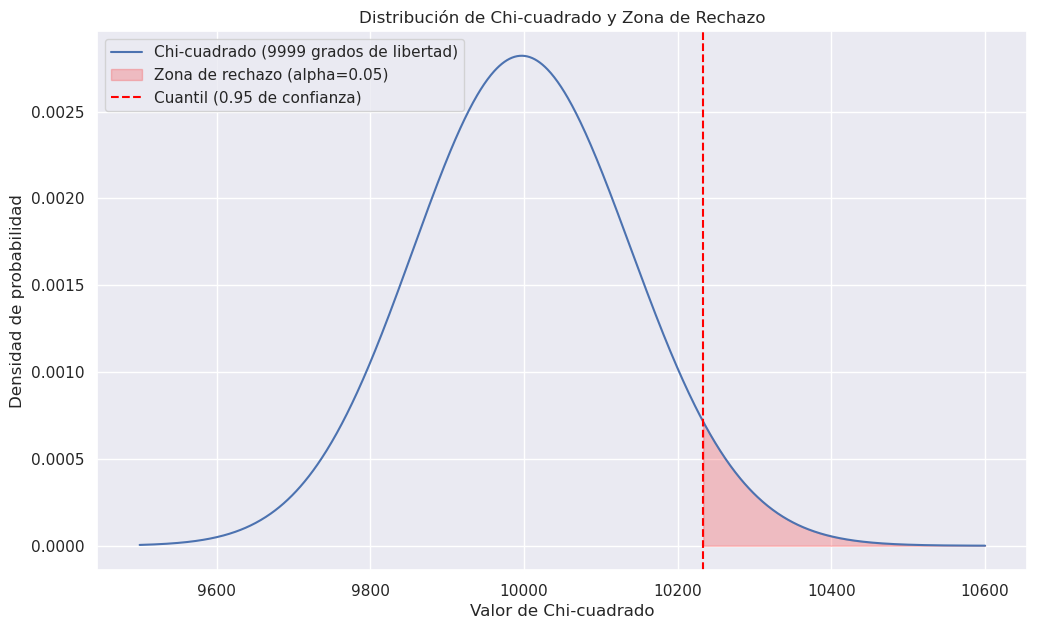

In [10]:
# Calculamos la zona de rechazo
alpha = 0.05
grados_libertad = cantidad_arribos - 1
cuantil = stats.chi2.ppf(1 - alpha, df=grados_libertad)
print(f'El cuantil para el Chi^2 es: {cuantil}')

# Valores para el eje x (valores de Chi-cuadrado)
x = np.linspace(9_500, 10_600, 1000)

# Valores para la densidad de probabilidad de Chi-cuadrado
pdf = stats.chi2.pdf(x, grados_libertad)

# Gráfico de la densidad de probabilidad de Chi-cuadrado
plt.figure(figsize=(12, 7))
plt.plot(x, pdf, label=f'Chi-cuadrado ({grados_libertad} grados de libertad)')
plt.fill_between(x, pdf, where=(x > cuantil), alpha=0.2, color='red', label=f'Zona de rechazo (alpha={alpha})')

# Línea vertical en el cuantil
plt.axvline(cuantil, color='red', linestyle='--', label=f'Cuantil ({1 - alpha} de confianza)')

plt.xlabel('Valor de Chi-cuadrado')
plt.ylabel('Densidad de probabilidad')
plt.title('Distribución de Chi-cuadrado y Zona de Rechazo')
plt.legend(loc='upper left')

plt.show()

Los valores esperados para el test siempre serán los mismos, ya que la distribuición Exponencial es una distribuición de parámetro fijo, y por lo tanto, los valores esperados serán los mismos para todos los valores de $i$. Siendo $E[x] = \frac{1}{\lambda}$

Entonces definimos nuestra hipótesis nula $(H_0)$ y la hipótesis alternativa $(H_1)$:

$H_0$: Los datos siguen una distribución de Poisson.\
$H_1$: Los datos no siguen una distribución de Poisson.

Calculamos con los valores observados la decisión del test:

In [11]:
# Sabemos que el valor esperado siempre es 1/lambda, debido a que la distribuición que queremos comparar es exponecial
valor_esperado = 1/lambda_minutos

# Calculamos el Chi-cuadrado para la muestra
chi_cuadrado = 0
for tiempo in tiempos_en_minutos:
    chi_cuadrado += (tiempo - valor_esperado) ** 2 / valor_esperado

print(f'Chi-cuadrado: {chi_cuadrado}')

Chi-cuadrado: 63495.88157310537


como 1058 < 10232. Entonces no rechazamos $H_0$ y decimos que los números pseudoaleatorios provistos siguen un Proceso de Poisson de parámtero 9.889.

## Utilizando el generador implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes.

Para realizar la simulación de la llegada de vehículos durante un mes, utilizamos el método de la transformada inversa, ya que tenemos una distribuición exponencial de parámetro $\lambda = 9.889...$, podemos simular arribos hasta los 31 días del mes o 44640 minutos que son 31 días en minutos.\
Decidimos usar la distribuición exponencial debido a que calcular la transdormada inversa de una Poisson es muy complejo.

### Calculamos la transformada inversa de la distribuición exponencial

teniendo una distribuición uniforme $U(0, 1)$, podemos calcular la transformada inversa de la distribuición exponencial de la siguiente forma:

$F_U(u) = F_T(t)$. Despejamos t en función de u:

$$F_X(t_i) = 1-e^{- \lambda t_i} = F_U(u_i) = u_i$$
$$e^{- \lambda t_i} = 1 - u_i$$
$$- \lambda t_i = ln(1- u_i)$$
$$t_i = - \frac{1}{\lambda} \cdot ln(1 - u_i)$$




 y obtenemos la siguiente fórmula:

$$t = -\frac{1}{\lambda} \cdot ln(1 - u)$$

### Simulación de arribos de vehículos durante un mes

Simulamos llegadas de vehículos hasta los 44640 minutos y lo guardamos en un archivo para no simularlo muchas veces

In [12]:
# Entonces simulamos llegadas de vehículos hasta los 44640 minutos, y graficamos la cantidad de arribos en función del tiempo.
generador_aleatorio = MT19937(44640)
tiempos_simulados = []
tiempo_actual = 0

while tiempo_actual < 44640:
    tiempo_arribo = -np.log(1 - generador_aleatorio.next_uniforme()) / lambda_minutos
    tiempo_actual += tiempo_arribo
    tiempos_simulados.append(tiempo_arribo)

print(f'Cantidad de arribos simulados: {len(tiempos_simulados)}')
print(f'Tiempo max simulado: {max(tiempos_simulados)} minutos')
print(f'Tiempo min simulado: {min(tiempos_simulados)} minutos')


# Guardamos los tiempos simulados en un archivo
tiempos_simulados_archivo = 'simulacion_llegada_en_min_un_mes.txt'
with open(tiempos_simulados_archivo, 'w') as archivo:
    for tiempo in tiempos_simulados:
        archivo.write(f'{tiempo}\n')


# Graficamos los tiempos simulados y los tiempos del archivo
# plt.figure(figsize=(12, 7))
# plt.plot(tiempos_simulados, label='Tiempos del archivo')
# plt.xlabel('Tiempo')

Cantidad de arribos simulados: 7539
Tiempo max simulado: 73.84395374903657 minutos
Tiempo min simulado: 0.00014688132172969797 minutos


## Generar 1000 realizaciones del proceso de Poisson para estimar probabilidades

In [13]:
generador_aleatorio = MT19937(44640)
tiempos_simulados = []

# for _ in range(1000):
#     tiempo_actual = 0
#     vuelta_i = []
#     while tiempo_actual < 44640:
#         tiempo_arribo = -np.log(1 - generador_aleatorio.next_uniforme()) / lambda_minutos
#         tiempo_actual += tiempo_arribo
#         vuelta_i.append(tiempo_arribo)
#     tiempos_simulados.append(vuelta_i)

print(tiempos_simulados)

[]


1. Probabilidad de que el primer vehículo arribe antes de los 10 minutos.

In [14]:
cant_primeros_arribos_10_min = 0

for i in range(1000):
    if tiempos_simulados[i][0] < 10:
        cant_primeros_arribos_10_min += 1

print(cant_primeros_arribos_10_min / 1000)

IndexError: list index out of range

2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.

3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.



---



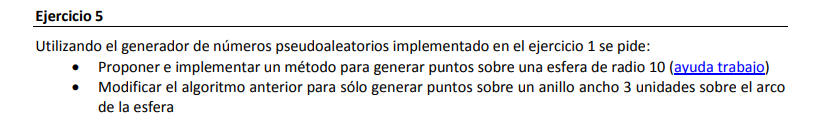

Link [ayuda](https://drive.google.com/file/d/1j9yLSLFdKLy5nOqO7Yys_rV_pv8x1Kau/view)

# Ejercicio 5:
Utilizando el generador de números pseudoaleatorios implementado en el ejercicio 1 se pide:


*   Proponer e implementar un método para generar puntos sobre una esfera de radio 10.
*   Modificar el algoritmo anterior para sólo generar puntos sobre un
anillo ancho 3 unidades sobre el arco de la esfera.





Para realizar este ejercicio vamos a utilizar coordenadas esféricas, en las cuales un punto en el espacio se define mediante tres valores: un radio (r) que toma valores de 0 a ∞, un ángulo polar (θ) que toma valores entre 0 y π, y  un ángulo azimutal (φ) que varía entre 0 y 2π. Las coordenadas cartesianas quedan entonces definidas como:
*   x = r * sin(θ) * cos(φ)
*   y = r * sin(θ) * sin(φ)
*   z = r * cos(θ)

Para generar puntos sobre una esfera de radio 10, vamos a generar por cada punto un número aleatorio entre 0 y π para definir θ, y un número aleatorio entre 0 y 2π para φ. Para esto generamos un número entre 0 y 1 y lo multiplicamos por π para definir θ, y generamos otro número entre 0 y 1 y lo multiplicamos por 2π para definir φ. El valor de r es constante e igual a 10. Una vez obtenidos θ y φ, ya podemos calcular las coordenadas cartesianas del punto con las definiciones establecidas previamente.


In [ ]:
radio = 10

def transformar_coordenadas_esfericas_a_cartesianas(radio, theta, phi):
    x = radio * np.sin(theta) * np.cos(phi)
    y = radio * np.sin(theta) * np.sin(phi)
    z = radio * np.cos(theta)
    return x, y, z

def generar_puntos_esfera():
    theta = generador() * np.pi
    phi = generador() * 2 * np.pi
    return transformar_coordenadas_esfericas_a_cartesianas(radio, theta, phi)

Para resolver el segundo punto vamos a utilizar coordenadas cilíndricas, las cuales se definen mediante tres valores: un radio (r) que respresenta la distancia al eje z y toma valores de 0 a ∞, un ángulo azimutal (φ) que varía entre 0 y 2π, y z que puede tomar valores de -∞ a ∞. Las coordenadas cartesianas quedan entonces definidas como:

*   x = r * cos(φ)
*   y = r * sen(φ)
*   z = z

Para generar puntos sobre un anillo de ancho 3 unidades sobre el arco de la esfera vamos a generar un valor aleatorio para φ y un valor aleatorio para r. En este caso z es constante e igual a 0 ya que el anillo se encuentra contenido en el plano xy (la esfera es simétrica con respecto a ese plano). El valor de r se va a encontrar dentro del rango del anillo, es decir, va a ser mayor al radio interior y menor al radio exterior. En este caso:

*   r(int) = r(esfera) - ancho/2 = 10 - 1.5 = 8.5
*   r(ext) = r(esfera) + ancho/2 = 10 + 1.5 = 11.5

Entonces, para generar un valor aleatorio para 8.5 ≤ r ≤ 11.5, generamos un número aleatorio entre 0 y 1, lo multiplicamos por 3 para ajustarlo al ancho establecido y le sumamos 8.5 para que caiga dentro del anillo que contiene al arco de la esfera. El valor de φ se genera de la misma forma que en el punto anterior (generando un número aleatorio entr 0 y 1 y multiplicandolo por 2π). El valor de z es constante como se explicó anteriormente.Luego se calculan las coordenadas cartesianas con esos valores de r y φ.

In [ ]:
ancho = 3
z = 0

def transformar_coordenadas_cilindricas_a_cartesianas(radio, phi, z):
    x = radio * np.cos(phi)
    y = radio * np.sin(phi)
    return x, y, z

def generar_puntos_anillo():
    radio = generador() * ancho + (radio - ancho / 2)
    phi = generador() * 2 * np.pi
    return transformar_coordenadas_cilindricas_a_cartesianas(radio, phi, z)